# Sentiment Analysis Between Communities

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

#### Load data, split post properties into columns, create networkx graphs

In [2]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

# separate post properties into different columns
post_colnames_df = pd.read_csv("post_properties_column_names.csv")
col_list = list(post_colnames_df['Colname'].values)
df_full[col_list] = df_full.loc[:,'PROPERTIES'].str.split(',', expand=True)
df_full[col_list] = df_full[col_list].astype(float) # correct datatype

## filter by political subreddits
# read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]

# filter dataframe 
source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

# keep only connections where both are political
df = df_full[source_is_political & target_is_political]
df_psource = df_full[source_is_political]
df_ptarget = df_full[target_is_political]

# create graphs
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
G_directed = nx.from_pandas_edgelist(edgelist_df, source=source, target=target, create_using=nx.DiGraph(),edge_attr="count")
G_undirected = G_directed.to_undirected()

#### Use Louvain Community Detection

In [3]:
# Compute the best partition
partition = community_louvain.best_partition(G_undirected, weight='count')

nx.set_node_attributes(G_undirected, partition, 'community')

# transform to list of community sets
partition_df = pd.DataFrame({'subreddit': partition.keys(), 'community':partition.values()})
communities = partition_df.groupby(by='community').agg(set)['subreddit'].tolist()

# Select the top three nodes with the highest degree in each community for labeling
community_labels = {}
for community in set(partition.values()):
    community_nodes = [node for node in partition if partition[node] == community]
    
    top_nodes = sorted(community_nodes, key=lambda node: G_undirected.degree(node), reverse=True)[:3]

    community_labels[community] = top_nodes

# Add communities to dataframe
df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_83258/3642016997.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_83258/3642016997.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)


## Sentiment Analysis
- uses both link sentiment (0/1) in dataframe column, and post sentiment in post properties vector
- show value counts 

LINK_SENTIMENT
 1    289
-1     42
Name: count, dtype: int64 


LINK_SENTIMENT
 1    2202
-1     331
Name: count, dtype: int64 


LINK_SENTIMENT
 1    2673
-1     485
Name: count, dtype: int64 


LINK_SENTIMENT
 1    265491
-1     21070
Name: count, dtype: int64 




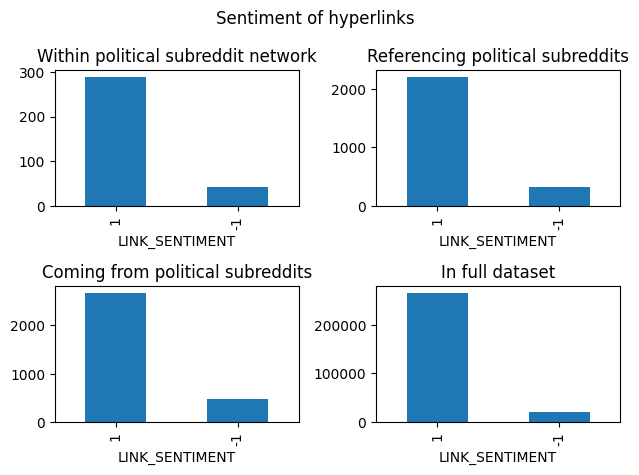

In [4]:
def sentiment_value_counts(df, ax):
    value_counts = df['LINK_SENTIMENT'].value_counts()
    print(value_counts, "\n\n")
    df['LINK_SENTIMENT'].value_counts().plot(kind='bar', ax=ax)
    
fig, axs = plt.subplots(2,2)

for ax, data in zip(axs.flatten(), [df, df_psource, df_ptarget, df_full]):
    sentiment_value_counts(data, ax)

axs[0][0].set_title("Within political subreddit network")
axs[1][0].set_title("Coming from political subreddits")
axs[0][1].set_title("Referencing political subreddits")
axs[1][1].set_title("In full dataset")
plt.suptitle("Sentiment of hyperlinks")
plt.tight_layout()
plt.show()

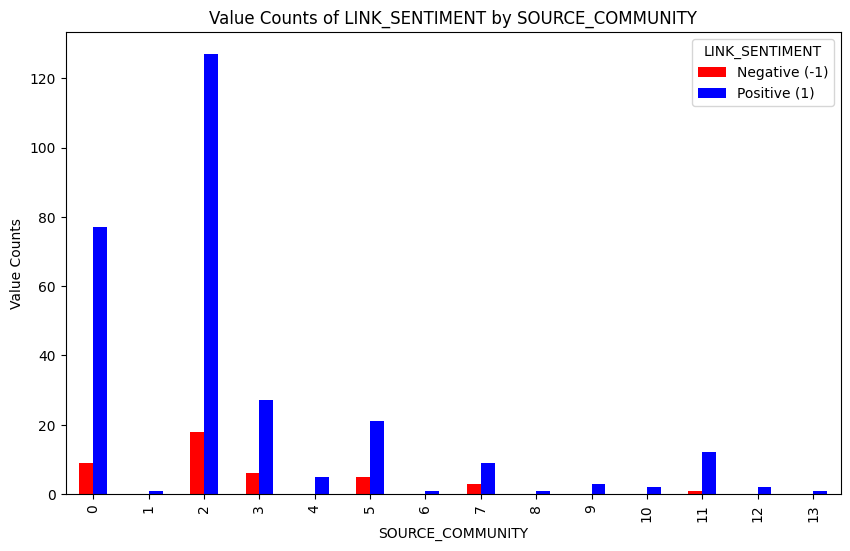

In [5]:
temp = df.groupby(by='SOURCE_COMMUNITY')['LINK_SENTIMENT'].value_counts()

temp = pd.Series(temp).unstack().fillna(0)  # Unstack to get LINK_SENTIMENT in columns
temp.index = temp.index.astype(int)  # Convert index to integers for sorting
temp = temp.sort_index()  # Sort by SOURCE_COMMUNITY for a cleaner plot
temp.plot(kind='bar', stacked=False, color=['red', 'blue'], figsize=(10, 6))
plt.xlabel('SOURCE_COMMUNITY')
plt.ylabel('Value Counts')
plt.title('Value Counts of LINK_SENTIMENT by SOURCE_COMMUNITY')
plt.legend(title='LINK_SENTIMENT', labels=['Negative (-1)', 'Positive (1)'])
plt.show()

COMMUNITY 	 POSITIVITY 	 NEGATIVITY
   ['socialism', 'communism101', 'communism'], 0.09, 0.06
   ['mmt_economics', 'ronpaul'], 0.15, 0.08
   ['politics', 'badeconomics', 'badpolitics'], 0.09, 0.08
   ['worldpolitics', 'syriancivilwar', 'agitation'], 0.08, 0.07
   ['prolife', 'prochoice'], 0.05, 0.02
   ['ukpolitics', 'metanarchism', 'ukipparty'], 0.10, 0.11
   ['futuristparty', 'restorethefourth'], 0.12, 0.11
   ['gunpolitics', 'progun', 'shitguncontrollerssay'], 0.06, 0.11
   ['demsocialist', 'acteuropa'], 0.19, 0.21
   ['thedavidpakmanshow', 'daverubin', 'georgism'], 0.12, 0.08
   ['law', 'scotus'], 0.08, 0.11
   ['samharris', 'altright', 'politicalfactchecking'], 0.10, 0.09
   ['europes', 'europeans', 'europeannationalism'], 0.04, 0.15
   ['liberalgunowners', 'guncontrol'], 0.09, 0.14


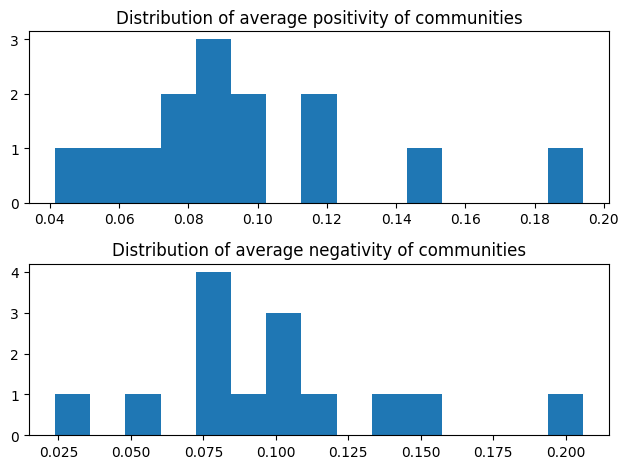

In [6]:
# calculate average positivity and negativity of louvain communities
def calculate_avg_sentiment(communities, is_target=False):
    """
    communities :  list where each entry is a set of subreddit names in the same community
                    e.g. [{'daverubin', 'georgism', 'thedavidpakmanshow'},
                         {'europeannationalism', 'europeans', 'europes'},
                         {'guncontrol', 'liberalgunowners'}, ...]
    is_target   :  if false, calculates average sentiment of posts written by each community
                   if true, calculates average sentiment of posts that hyperlink each community

    returns lists of average sentiment for each community
    """
    community_positive_avg = []
    community_negative_avg = []

    if is_target:
        col = 'TARGET_SUBREDDIT'
    else:
        col = 'SOURCE_SUBREDDIT'
    
    for i, community in enumerate(communities):
        positives = []
        negatives = []
        community_df = df[df[col].isin(community)]

        # get values from property vector
        properties = community_df["PROPERTIES"].str.split(',')
        positive = properties.apply(lambda x: float(x[18])).mean().item()
        negative = properties.apply(lambda x: float(x[19])).mean().item()
    
        community_positive_avg.append(positive)
        community_negative_avg.append(negative)

    return community_positive_avg, community_negative_avg


community_positive_avg, community_negative_avg = calculate_avg_sentiment(communities)

print("COMMUNITY \t POSITIVITY \t NEGATIVITY")
for label, positivity, negativity in zip(community_labels.values(), community_positive_avg, community_negative_avg):
    print(f"   {label}, {positivity:.2f}, {negativity:.2f}")

# plots
fig, ax = plt.subplots(2,1)
ax[0].hist(community_positive_avg, bins=15)
ax[0].set_title("Distribution of average positivity of communities")
ax[1].hist(community_negative_avg, bins=15)
ax[1].set_title("Distribution of average negativity of communities")
plt.tight_layout()
plt.show()

Average sentiment of posts linking this community:
--------------------------------------------------
COMMUNITY 	 POSITIVITY 	 NEGATIVITY
   ['socialism', 'communism101', 'communism'], 0.08, 0.06
   ['mmt_economics', 'ronpaul'], 0.15, 0.08
   ['politics', 'badeconomics', 'badpolitics'], 0.09, 0.08
   ['worldpolitics', 'syriancivilwar', 'agitation'], 0.08, 0.09
   ['prolife', 'prochoice'], 0.05, 0.03
   ['ukpolitics', 'metanarchism', 'ukipparty'], 0.09, 0.09
   ['futuristparty', 'restorethefourth'], 0.12, 0.11
   ['gunpolitics', 'progun', 'shitguncontrollerssay'], 0.07, 0.12
   ['demsocialist', 'acteuropa'], 0.19, 0.21
   ['thedavidpakmanshow', 'daverubin', 'georgism'], 0.13, 0.02
   ['law', 'scotus'], 0.00, 0.18
   ['samharris', 'altright', 'politicalfactchecking'], 0.10, 0.10
   ['europes', 'europeans', 'europeannationalism'], 0.04, 0.15
   ['liberalgunowners', 'guncontrol'], 0.09, 0.14


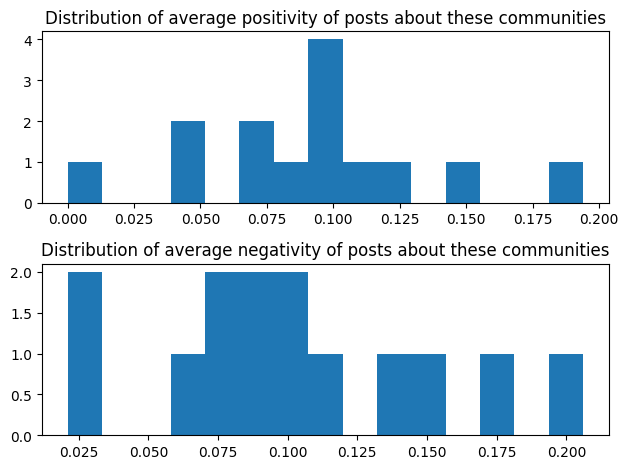

In [7]:
community_positive_avg, community_negative_avg = calculate_avg_sentiment(communities, is_target=True)

print("Average sentiment of posts linking this community:")
print("-"*50)
print("COMMUNITY \t POSITIVITY \t NEGATIVITY")
for label, positivity, negativity in zip(community_labels.values(), community_positive_avg, community_negative_avg):
    print(f"   {label}, {positivity:.2f}, {negativity:.2f}")

# plots
fig, ax = plt.subplots(2,1)
ax[0].hist(community_positive_avg, bins=15)
ax[0].set_title("Distribution of average positivity of posts about these communities")
ax[1].hist(community_negative_avg, bins=15)
ax[1].set_title("Distribution of average negativity of posts about these communities")
plt.tight_layout()
plt.show()